In [0]:
!mkdir data
!wget -P data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n data/train-test-data.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/test/Elmar_Brok_30.jpg  
  inflating: data/test/Elmar_Brok_31.jpg  
  inflating: data/test/Elsa_Zylberstein_00.jpg  
  inflating: data/test/Elsa_Zylberstein_01.jpg  
  inflating: data/test/Elsa_Zylberstein_10.jpg  
  inflating: data/test/Elsa_Zylberstein_11.jpg  
  inflating: data/test/Elsa_Zylberstein_40.jpg  
  inflating: data/test/Elsa_Zylberstein_41.jpg  
  inflating: data/test/Elton_John_10.jpg  
  inflating: data/test/Elton_John_11.jpg  
  inflating: data/test/Elton_John_20.jpg  
  inflating: data/test/Elton_John_21.jpg  
  inflating: data/test/Elton_John_30.jpg  
  inflating: data/test/Elton_John_31.jpg  
  inflating: data/test/Elton_John_40.jpg  
  inflating: data/test/Elton_John_41.jpg  
  inflating: data/test/Emile_Lahoud_00.jpg  
  inflating: data/test/Emile_Lahoud_01.jpg  
  inflating: data/test/Emile_Lahoud_30.jpg  
  inflating: data/test/Emile_Lahoud_31.jpg  
  inflating: data/test/Emile_Lahoud_40.jpg  


In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.image as mpimg
import cv2
%matplotlib inline

You can read this artical to understand excatly how this clas work [link text](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [0]:
class FacialKeyPointsDataset(tf.keras.utils.Sequence):
    def __init__(self, csv_file, root_dir, output_size, batch_size, shuffle=False, normalization="vector"):
        """
        initializing a generator for a spacific data directory
        Args:
            csv_file: the file that contains the points values and the names of the images
            root_dir: the directory that contains all the images
            output_size: the size of the output image after preprocessing
            batch_size: what kind of explanation is needed here !!
            shuffle: do you want to shuffle the data?
        """
        self.keypts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.output_size = output_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # the mean and std vectors are going to be used in the normalized methods
        # we also need them to be public properties of the object since we will need them
        # after predicting the keypoints to undo normalization
        
        # I am trying different normalization methods for the keypoints
        # spoiler alert: the vector normalization works best as expected because I am a genious
        if normalization == 'scaler':
            self.mean = self.keypts_frame.iloc[:, 1:].values.mean()
            self.std = self.keypts_frame.iloc[:, 1:].values.std()
        elif normalization == 'vector':
            self.mean = self.keypts_frame.iloc[:, 1:].values.mean(axis=0).reshape(-1, 1)
            self.std = self.keypts_frame.iloc[:, 1:].values.std(axis=0).reshape(-1, 1)
        elif normalization == 'none':
            self.mean = 0
            self.std = 1
        else:
            raise ValueError("normalization must be one of 'scaler', 'vector', or 'none'")
        
        self.on_epoch_end()


    def on_epoch_end(self):
        """ This function gets called after each epoch, duh!"""
        
        # all possible indecies in the dataframe
        self.indecies = np.arange(len(self.keypts_frame))
        if self.shuffle:
            np.random.shuffle(self.indecies)


    def __len__(self):
        """ The generator returns one batch at a time so it makes sence that it would have
        a length equal to the number of samples divided by the batch size
        giving the total number of batches
        """
        return int(len(self.keypts_frame) / self.batch_size)

    def __getitem__(self, idx):
        """ This is where the magic hapenes, the model will call this function using the
        indexing operator 'generator[0]' or whatever.
        then and only then will the generator load the batch into memory and the garbage collector
        will remove it on the next iteration
        
        """
        # initialize the batch as empty arrays
        X = np.empty((self.batch_size, *self.output_size, 1))
        y = np.empty((self.batch_size, 136, 1))
        
        # get the indecies of the current batch only
        indecies = self.indecies[idx*self.batch_size:(idx+1)*self.batch_size]

        for index in range(len(indecies)):
            # get the image name
            image_name = os.path.join(self.root_dir,
                                    self.keypts_frame.iloc[indecies[index], 0])
            # load the image data
            image = mpimg.imread(image_name)
            
            # if image has an alpha color channel, get rid of it
            if(image.shape[2] == 4):
                image = image[:,:,0:3]
            
            # get the associated key points
            key_pts = self.keypts_frame.iloc[indecies[index], 1:].to_numpy()
            
            # process the image and the keypoints
            image, key_pts = self.preprocess_train(image, key_pts)
            image = image.reshape(*self.output_size, 1).astype(np.float32)
            key_pts = key_pts.astype(np.float32)
            
            # add the image data to the initialized arrays
            X[index,] = image
            y[index] = key_pts
        # return batch
        return X, y
    
    def preprocess_train(self, image, key_pts):
        image, key_pts = self.__rescale(image, key_pts)
        image, key_pts = self.__randomCrop(image, key_pts)
        image, key_pts = self.__normalize(image, key_pts)
        return image, key_pts
    
    def preprocess_test(self, image):
        key_pts = np.random.rand(136, 1)
        image, key_pts = self.__rescale(image, key_pts, train=False)
        image, key_pts = self.__normalize(image, key_pts)
        return image
        

    def __normalize(self, image, key_pts):
        """ Normailze image and key points
        Args:
            image: the image to be normalized
            key_pts: the associated key points
        Returns:
            image_copy: normalized image
            key_pts_copy: normalized key points numpy array of size (136, 1)
        """
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        key_pts_copy = (key_pts_copy - self.mean)/self.std
        return image_copy, key_pts_copy
    
    def __randomCrop(self, image, key_pts):
        key_pts = key_pts.reshape(-1, 2)
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return image, key_pts.reshape(-1, 1)
    
    def __rescale(self, image, key_pts, train=True):
        key_pts = key_pts.reshape(-1, 2)
        h, w = image.shape[:2]

        new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        # to be cropped later
        if train:
            new_h = new_h + 4
            new_w = new_w + 4
        
        
        img = cv2.resize(image, (new_w, new_h))
        
        key_pts = key_pts * [new_w / w, new_h / h]

        return img, key_pts.reshape(-1, 1)


In [0]:
datagenerator = FacialKeyPointsDataset(csv_file='data/training_frames_keypoints.csv',
                                         root_dir='data/training/',
                                         output_size=(194, 194),
                                         batch_size=30)

print(len(datagenerator))
X_batch, y_batch = datagenerator[len(datagenerator)-1]
print(X_batch.shape, y_batch.shape)

115
(30, 194, 194, 1) (30, 136, 1)


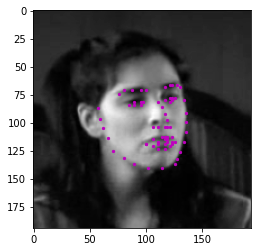

In [0]:
import matplotlib.pyplot as plt
plt.imshow(X_batch[0].reshape(194, 194), cmap="gray")
keypts = y_batch[0] * datagenerator.std + datagenerator.mean
keypts = keypts.reshape(-1, 2)
plt.scatter(keypts[:, 0], keypts[:, 1], marker=".", s=20, color="m")


Read this [link text](https://https://github.com/mahmoudyusof/facial_keypoint_detection/blob/master/2.1%20Create%2C%20train%20and%20store%20the%20model%20the%20right%20way.ipynb) notbook in  mahmoudyusof rep

In [0]:
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Flatten, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
import os
# The class we've created in the previous notebook
#from datagenerator import FacialKeyPointsDataset
datagenerator = FacialKeyPointsDataset(csv_file='data/training_frames_keypoints.csv',
                                         root_dir='data/training/',
                                         output_size=(194, 194),
                                         batch_size=30)

print(len(datagenerator))
X_batch, y_batch = datagenerator[len(datagenerator)-1]
print(X_batch.shape, y_batch.shape)

115
(30, 194, 194, 1) (30, 136, 1)


In [0]:
model = Sequential([
    Conv2D(16, 3, input_shape=[194, 194, 1], activation="relu"),
    BatchNormalization(),
    MaxPool2D(),

    Conv2D(32, 3, activation="relu"),
    BatchNormalization(),
    MaxPool2D(),

    Conv2D(64, 3, activation="relu"),
    BatchNormalization(),
    MaxPool2D(),

    Conv2D(128, 3, activation="relu"),
    BatchNormalization(),
    MaxPool2D(),

    Conv2D(256, 3, activation="relu"),
    BatchNormalization(),
    MaxPool2D(),

    Conv2D(512, 3, activation="relu"),
    BatchNormalization(),
    MaxPool2D(),

    Flatten(),

    Dense(512, activation="relu"),
    BatchNormalization(),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dense(512, activation="relu"),
    BatchNormalization(),

    Dense(136)
])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 192, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 94, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        1

In [0]:
data_generator = FacialKeyPointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             output_size=(194, 194),
                                             batch_size=10,
                                             normalization="vector")

In [0]:
tf.keras.backend.clear_session()
model.compile(
    loss=tf.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(0.005),
    metrics=['accuracy']
)

In [0]:
earlyStopping = EarlyStopping(monitor='loss', patience=10, verbose=0, mode='min')
history = model.fit(data_generator, epochs=3, callbacks=[earlyStopping])

Epoch 1/3
346/346 [==============================] - 212s 611ms/step - loss: 0.0941 - accuracy: 0.0266
Epoch 2/3
346/346 [==============================] - 211s 611ms/step - loss: 0.0656 - accuracy: 0.0370
Epoch 3/3
346/346 [==============================] - 215s 620ms/step - loss: 0.0544 - accuracy: 0.0442


In [0]:
model_json = model.to_json()
with open("/content/dummy_model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("/content/dummy_model.h5")

In [0]:
json_file = open('/content/model_vector_batchnorm_194.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/content/model_vector_batchnorm_194.h5")

JSONDecodeError: ignored

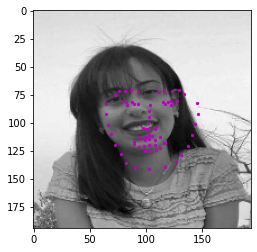

In [0]:
img = mpimg.imread("/content/mm.jpg")
# preprocess the image using the data generator
img = data_generator.preprocess_test(img)
# get the prediction, here we reshape the image to make a batch of one image
keypts = model.predict(img.reshape(1, 194, 194, 1)).reshape(-1, 1)
# undo keypoint normalization ... see those attribures? remember them?
# if you don't, refer to the notebook 1.1
keypts = keypts * data_generator.std + data_generator.mean
# create point ordered pairs
keypts = keypts.reshape(-1, 2)

plt.imshow(img.reshape(194, 194), cmap="gray")
plt.scatter(keypts[:, 0], keypts[:, 1], marker=".", s=20, color="m")
plt.show()

**The comming section is related to Fun Part Get Ready**

In [0]:
import cv2
import numpy as np
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#from datagenerator import FacialKeyPointsDataset
datagenerator = FacialKeyPointsDataset(csv_file='data/training_frames_keypoints.csv',
                                         root_dir='data/training/',
                                         output_size=(194, 194),
                                         batch_size=30)

from tensorflow.keras.models import model_from_json
%matplotlib inline

TEST_IMG = "/content/Fullpic.jpg"

Detect the Face You will know more about it im my repo"OpenCV"
Good Luck man! 

In [0]:
def detectFace(image):
    # load in a haar cascade classifier for detecting frontal faces
    face_cascade = cv2.CascadeClassifier(
        '/content/haarcascade_frontalface_default.xml')

    # run the detector
    faces = face_cascade.detectMultiScale(image, 1.2, 10, 30)

    # make a copy of the original image to plot detections on
    image_with_detections = image.copy()

    # loop over the detected faces, mark the image where each face is found
    for (x, y, w, h) in faces:
        # draw a rectangle around each detected face
        cv2.putText(image_with_detections, 'Hooman', (x, y-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
        cv2.rectangle(image_with_detections, (x, y),
                      (x + w, y + h), (0, 0, 255), 3)

    return image_with_detections, faces

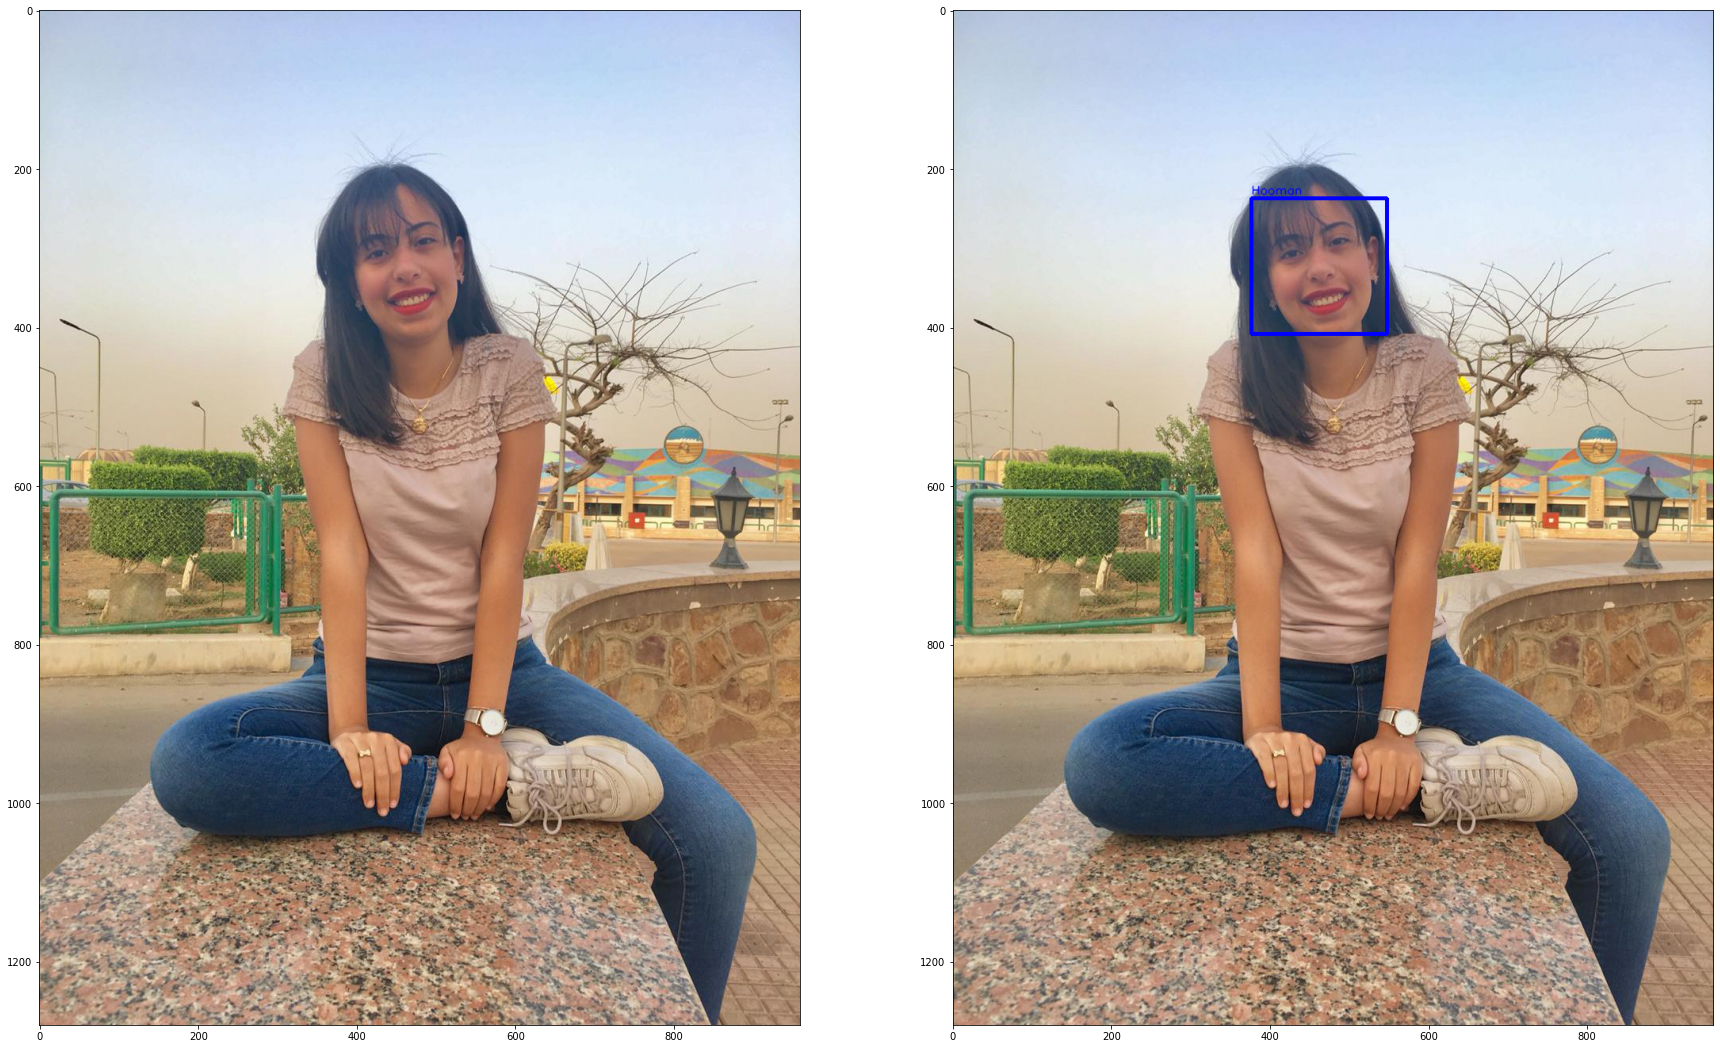

In [0]:
img = mpimg.imread(TEST_IMG)
img_with_faces, faces = detectFace(img)

plt.figure(figsize=(30, 30))

plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(img_with_faces)

Cut interested area

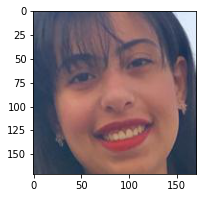

In [0]:
plt.figure(figsize=(3*len(faces), 3*len(faces)))
idx = 1
for (x, y, h, w) in faces:
    roi = img[y:y+h, x:x+w]
    plt.subplot(1, len(faces), idx)
    plt.imshow(roi)
    idx = idx + 1


In [0]:
json_file = open(
    '/content/model_vector_batchnorm_194.json',
    'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(
    "/content/model_vector_batchnorm_194.h5")
print("Loaded model from disk")


datasetgen = FacialKeyPointsDataset(csv_file='/content/data/training_frames_keypoints.csv',
                                    root_dir='/content/data/training/',
                                    normalization="vector")

JSONDecodeError: ignored

In [0]:
datasetgen = FacialKeyPointsDataset(csv_file='data/training_frames_keypoints.csv',
                                         root_dir='data/training/',
                                         output_size=(194, 194),
                                         batch_size=30,
                                    normalization="vector")

def get_key_points(frame, face):
    # the padding, that guy has a huge chin that we need to be visible in the image
    pad = 50
    (x, y, w, h) = face
    # get the region of interes, this time with padding
    roi = frame[y - pad:y + h + pad, x - pad:x + w + pad]
    # we'll need the original size to rescale the image back to it
    originalSize = roi.shape
    if(originalSize[0] == 0 or originalSize[1] == 0):
        return (), roi, originalSize, (0, 0, 0, 0)
    
    roi = cv2.resize(roi, datasetgen.output_size)
    
    # preprocess the roi before prediction
    img = datasetgen.preprocess_test(roi)
    
    # make a batch from the image
    img = img.reshape(1, *img.shape, 1)
    keypts = model.predict(img).reshape(-1, 1)
    keypts = keypts * datasetgen.std + datasetgen.mean
    keypts = keypts.reshape(-1, 2)

    return keypts, roi, originalSize, (x-pad, y-pad, w+pad*2, h+pad*2)

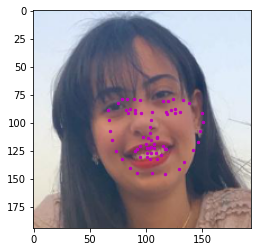

In [0]:
img = mpimg.imread(TEST_IMG)
plt.figure(figsize=(4*len(faces), 4*len(faces)))
idx = 1
for face in faces:
    keypts, roi, originalSize, padded = get_key_points(img, face)
    plt.subplot(1, len(faces), idx)
    plt.imshow(roi)
    plt.scatter(keypts[:, 0], keypts[:, 1], marker=".", s=23, color="m")
    idx = idx + 1

In [0]:
class Filter:
    def __init__(self, path, coord, h_points, w_points, offset=(0, 0), padding=(0, 0)):
        self.img = mpimg.imread(path, -1)
        self.coord = coord
        self.h_points = h_points
        self.w_points = w_points
        self.offset = offset
        self.padding = padding
        
    def apply(self, keypts, roi):
        """ Apply the filter given the keypts on the given frame
        Args:
            keypts: the keypoints array
            roi: the face image to which you want to apply the filter
        """
        w = int(abs(
            keypts[ self.w_points[0] ][0] - keypts[ self.w_points[1] ][0]
        )) + self.padding[0]

        h = int(abs(
            keypts[ self.h_points[0] ][1] - keypts[ self.h_points[1] ][1]
        )) + self.padding[1]

        filter_img = cv2.resize(self.img, (w, h), interpolation=cv2.INTER_CUBIC)

        x = int(keypts[self.coord][0]) + self.offset[0]
        y = int(keypts[self.coord][1]) + self.offset[1]

        roi_color = roi[y:y + h, x:x + w]

        non_trans = np.argwhere(filter_img[:, :, 3] > 0)

        if(non_trans.shape[0] > roi_color.shape[0]*roi_color.shape[1]):
            return roi

        roi_color[non_trans[:, 0], non_trans[:, 1],
                  :3] = filter_img[non_trans[:, 0], non_trans[:, 1], :3]
        roi[y:y + h, x:x + w] = roi_color
        
        return roi
        

filter1 = Filter(
        path="/content/filter1.png",
        coord=17,
        h_points=(25, 29),
        w_points=(2, 16),
        offset=(-10, 0)
)

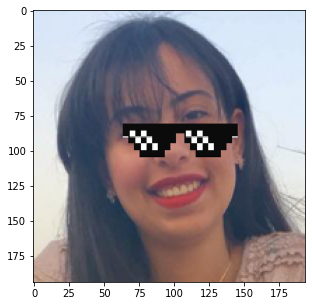

In [0]:
img = mpimg.imread(TEST_IMG)
plt.figure(figsize=(5, 5))
idx = 1
for face in faces:
    keypts, roi, originalSize, padded = get_key_points(img, face)
    plt.subplot(1, len(faces), idx)
    plt.imshow(filter1.apply(keypts, roi))
    idx = idx + 1

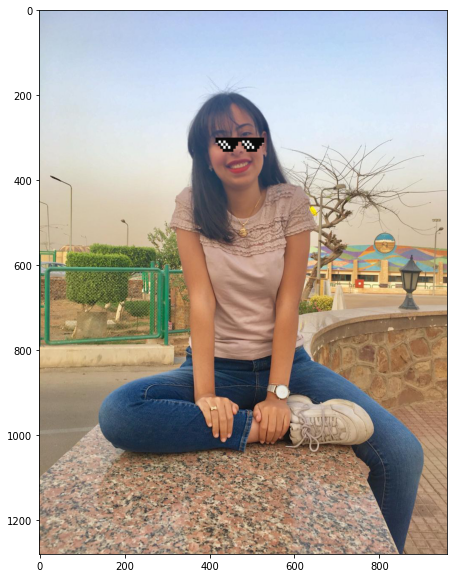

In [0]:
img = mpimg.imread(TEST_IMG).copy() # if you don't copy you'll get an immutable array and you don't want that

# detect faces
img_with_faces, faces = detectFace(img)

# iterate over faces and get keypoints for each face
for face in faces:
    keypts, roi, originalSize, (x, y, w, h) = get_key_points(img, face)
    roi = filter1.apply(keypts, roi)
    roi = cv2.resize(roi, (originalSize[:2]))
    img[y:y + h, x:x + w] = roi
    
plt.figure(figsize=(10, 10))
plt.imshow(img)